# Assignment 2: Visualization, Covariance and Correlation

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [2]:
from mls import locate_data
pong_data = pd.read_hdf(locate_data('pong_data.hf5'))
pong_targets = pd.read_hdf(locate_data('pong_targets.hf5'))

### Problem 1

We often coerce data for machine learning into a 2D array of samples x features, but this sometimes obscures the natural structure of the data.  In these cases, it is helpful to use special-purpose visualizations that know about this natural structure.

Samples of `pong_data` encode 2D trajectories of a ping-pong ball. Implement the function below to transform one sample into a 2D array of trajectory coordinates suitable for plotting:

In [3]:
def sample_to_trajectory(sample):
    """Reshape a pong data sample of length N into an (x,y) array of shape (2, N/2).
    
    Parameters
    ----------
    sample : array
        Numpy array of length N.
    
    Returns
    -------
    array
        Array of length (2, N/2) where the first index is 0, 1 for x, y coordinates.
    """
    assert len(sample) % 2 == 0, 'len(sample) is not divisible by two.'
    ### BEGIN SOLUTION
    nxy = len(sample) // 2
    return sample.reshape((2, nxy))
    ### END SOLUTION

In [4]:
# A correct solution should pass these tests.
sample = np.arange(10)
xy = sample_to_trajectory(sample)
assert xy.shape == (2, 5)
assert np.array_equal(xy[0], [0, 1, 2, 3, 4])
assert np.array_equal(xy[1], [5, 6, 7, 8, 9])

Use the function below to plot some samples as trajectories, color coded by their target "grp" value:

In [5]:
def plot_trajectories(nrows=50):
    for row in range(nrows):
        x, y = sample_to_trajectory(pong_data.iloc[row].values)
        grp = int(pong_targets['grp'][row])
        color = 'krb'[grp]
        plt.plot(x, y, ls='-', c=color)

In [6]:
#plot_trajectories()

It should be obvious from this plot why the `y0` column is all zeros.

Implement the function below using `sns.distplot` to show the distribution of `x0` values for each value (0, 1, 2) of the target `grp`.  Your plot should resemble this one:
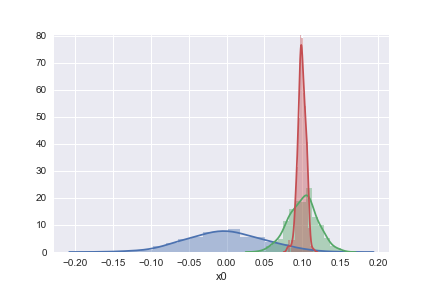

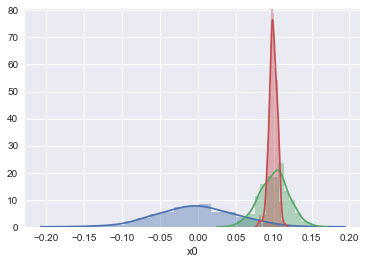

In [7]:
def compare_groups():
    """Plot 1D distributions of the x0 feature for each group (grp=0,1,2).
    """
    ### BEGIN SOLUTION
    grp0 = pong_data[pong_targets['grp'] == 0]
    grp1 = pong_data[pong_targets['grp'] == 1]
    grp2 = pong_data[pong_targets['grp'] == 2]
    sns.distplot(grp0['x0'], label='grp0')
    sns.distplot(grp1['x0'], label='grp1')
    sns.distplot(grp2['x0'], label='grp2')
    plt.savefig('compare_groups.png')
    ### END SOLUTION
    
compare_groups()

To get some insight into the `th0` target, implement the function below to add a `slope` column to `pong_data` that calculates the initial trajectory slope, then make a scatter plot of `slope` versus `th0` using `sns.jointplot`.  Your plot should resemble this one:
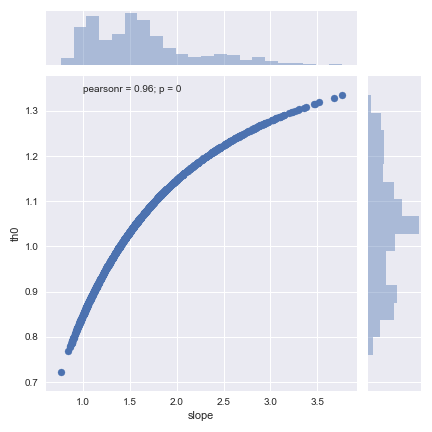

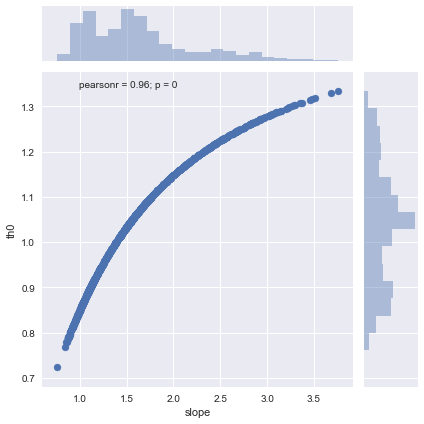

In [8]:
def compare_slope_th0():
    """Display scatter plot of calculated initial slope vs target th0.
    """
    ### BEGIN SOLUTION
    pong_data['slope'] = (pong_data['y1'] - pong_data['y0']) / (pong_data['x1'] - pong_data['x0'])
    sns.jointplot(pong_data['slope'], pong_targets['th0'], kind='scatter')
    plt.savefig('compare_slope_th0.png')
    ### END SOLUTION
    
compare_slope_th0()

### Problem 2

The normal (aka Gaussian) distribution is one of the fundamental probability densities that we will encounter often.

Implement the function below using `np.random.multivariate_normal` to generate random samples from an arbitrary multidimensional normal distribution, for a specified random seed:

In [9]:
def generate_normal(mu, C, n, seed=123):
    """Generate random samples from a normal distribution.
    
    Parameters
    ----------
    mu : array
        1D array of mean values of length N.
    C : array
        2D array of covariances of shape (N, N). Must be a positive-definite matrix.
    n : int
        Number of random samples to generate.
    seed : int
        Random number seed to use.
        
    Returns
    -------
    array
        2D array of shape (n, N) where each row is a random N-dimensional sample.
    """
    assert len(mu.shape) == 1, 'mu must be 1D.'
    assert C.shape == (len(mu), len(mu)), 'C must be N x N.'
    assert np.all(np.linalg.eigvals(C) > 0), 'C must be positive definite.'
    ### BEGIN SOLUTION
    gen = np.random.RandomState(seed=seed)
    return gen.multivariate_normal(mu, C, size=n)
    ### END SOLUTION

In [10]:
# A correct solution should pass these tests.
mu = np.array([-1., 0., +1.])
C = np.identity(3)
C[0, 1] = C[1, 0] = -0.9
Xa = generate_normal(mu, C, n=500, seed=1)
Xb = generate_normal(mu, C, n=500, seed=1)
Xc = generate_normal(mu, C, n=500, seed=2)
assert np.array_equal(Xa, Xb)
assert not np.array_equal(Xb, Xc)
X = generate_normal(mu, C, n=2000, seed=3)
assert np.allclose(np.mean(X, axis=0), mu, rtol=0.001, atol=0.1)
assert np.allclose(np.cov(X, rowvar=False), C, rtol=0.001, atol=0.1)

Visualize a generated 3D dataset using:

In [11]:
def visualize_3d():
    mu = np.array([-1., 0., +1.])
    C = np.identity(3)
    C[0, 1] = C[1, 0] = -0.9
    X = generate_normal(mu, C, n=2000, seed=3)
    df = pd.DataFrame(X, columns=('x0', 'x1', 'x2'))
    sns.pairplot(df)

In [12]:
#visualize_3d()

Read about [correlation and covariance](https://en.wikipedia.org/wiki/Covariance_and_correlation), then implement the function below to create a 2x2 covariance matrix given values of $\sigma_x$, $\sigma_y$ and the correlation coefficient $\rho$:

In [13]:
def create_2d_covariance(sigma_x, sigma_y, rho):
    """Create and return the 2x2 covariance matrix specified by the input args.
    """
    assert (sigma_x > 0) and (sigma_y > 0), 'sigmas must be > 0.'
    ### BEGIN SOLUTION
    return np.array(
        [[sigma_x ** 2, rho * sigma_x * sigma_y],
         [rho * sigma_x * sigma_y, sigma_y ** 2]])
    ### END SOLUTION

In [14]:
# A correct solution should pass these tests.
assert np.array_equal(create_2d_covariance(1., 1., 0.0), [[1., 0.], [0., 1.]])
assert np.array_equal(create_2d_covariance(2., 1., 0.0), [[4., 0.], [0., 1.]])
assert np.array_equal(create_2d_covariance(2., 1., 0.5), [[4., 1.], [1., 1.]])
assert np.array_equal(create_2d_covariance(2., 1., -0.5), [[4., -1.], [-1., 1.]])

Run the following cell that uses your `create_2d_covariance` and `generate_normal` functions to compare the 2D normal distributions with $\rho = 0$ (blue), $\rho = +0.9$ (red) and $\rho = -0.9$ (green):

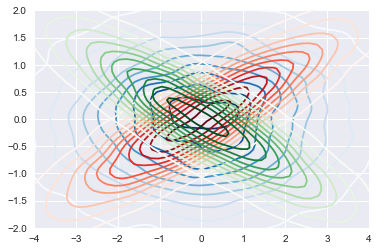

In [15]:
def compare_rhos():
    mu = np.zeros(2)
    sigma_x, sigma_y = 2., 1.
    for rho, cmap in zip((0., +0.9, -0.9), ('Blues', 'Reds', 'Greens')):
        C = create_2d_covariance(sigma_x, sigma_y, rho)
        X = generate_normal(mu, C, 10000)
        sns.kdeplot(X[:, 0], X[:, 1], cmap=cmap)
    plt.xlim(-4, +4)
    plt.ylim(-2, +2)
        
compare_rhos()